# Exploring with simple stats the surge data base of Heidi Sevestre

Sevestre and Benn, 2015: https://www.cambridge.org/core/journals/journal-of-glaciology/article/climatic-and-geometric-controls-on-the-global-distribution-of-surgetype-glaciers-implications-for-a-unifying-model-of-surging/34D15501CBBF803608401FEAA6B0FC61 The excel spreadsheet has been sent by Doug Benn on request.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt

### Import data

In [2]:
df = pd.read_excel('/home/colili/Documents/PhD/project_john/data_set/data_sevestre_benn/Surge_database_heidi.xlsx')

# lat and lon import as non-floats
df['CENLAT'] = df.CENLAT.astype(float)
df['CENLON'] = df.CENLON.astype(float)

print(df.shape)
# some rows have only nans for relevant data
df.dropna(inplace=True)
print(df.shape)

# create a column that tells us if a glacier is surgetype or not based on if it has observed surges
df['surgetype'] = df.apply(lambda x: 1 if x['Number of dated surges'] > 0 else 0, axis=1)

print('there are', df.RGI_ID.unique().shape, 'unique glaciers in the data set based on RGI_id')

print('there are', df[['Country', 'RGI_ID', 'GLIMS_ID', 
       'Number of dated surges', 'CENLAT', 'CENLON', 'AREA', 'ZMIN', 'ZMAX',
       'ZMED', 'SLOPE', 'ASPECT', 'LMAX']].drop_duplicates().shape, 'unique rows in the data set when removing the glacier name.')

# we need an actual thickness, this is a bad estimate
df['thickness'] = df.ZMAX - df.ZMIN

(2280, 14)
(2180, 14)
there are (1503,) unique glaciers in the data set based on RGI_id
there are (1669, 13) unique rows in the data set when removing the glacier name.


In [3]:
df.columns

Index(['Country', 'RGI_ID', 'GLIMS_ID', 'Glacier_Name',
       'Number of dated surges', 'CENLAT', 'CENLON', 'AREA', 'ZMIN', 'ZMAX',
       'ZMED', 'SLOPE', 'ASPECT', 'LMAX', 'surgetype', 'thickness'],
      dtype='object')

In [4]:
xcols = [ 'CENLAT', 'CENLON', 'AREA', 'ZMIN', 'ZMAX',
       'ZMED', 'SLOPE', 'ASPECT', 'LMAX', 'thickness']

ycol = 'surgetype'

X = df[xcols]
y = df[ycol]

### Divide the dataset between train/test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Apply logistic regression

In [6]:
lr = LogisticRegression(C=1, max_iter=1000)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.6222222222222222

### Apply gradient boosted model

In [7]:
xg = xgb.XGBClassifier(n_estimators=20000, max_depth=1,)
xg.fit(X_train, y_train)
xg.score(X_test, y_test)

0.7555555555555555

In [8]:
y_test.sum()/y_test.count()

0.36527777777777776

In [9]:
y_train.sum()/y_train.count()

0.34178082191780823

### Feature of importance from the gradient boosted model

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

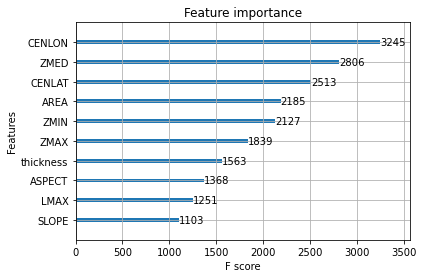

In [10]:
'''
it is likely the case this model works so well because it simply knows that surge type glaciers cluster in speicfic areas on earth which is why cenlon and cenlat are so important. especially when the physical model says that the slope should be the most important.
'''

xgb.plot_importance(xg)

### Correlation matrix

In [11]:
df.corr('spearman')

,Number of dated surges,CENLAT,CENLON,AREA,ZMIN,ZMAX,ZMED,SLOPE,ASPECT,LMAX,surgetype,thickness
Number of dated surges,1.000000,0.072734,0.027326,0.211616,-0.170595,-0.032058,-0.107996,-0.107992,0.090357,0.202715,0.983353,0.125415
CENLAT,0.072734,1.000000,-0.616156,0.304101,-0.830648,-0.828061,-0.859796,-0.572891,0.067703,0.232510,0.070319,-0.232362
CENLON,0.027326,-0.616156,1.000000,-0.272312,0.645405,0.564483,0.642414,0.344860,-0.038474,-0.257406,0.047286,-0.098202
AREA,0.211616,0.304101,-0.272312,1.000000,-0.501386,-0.007245,-0.247600,-0.522178,-0.079842,0.970122,0.195242,0.670417
ZMIN,-0.170595,-0.830648,0.645405,-0.501386,1.000000,0.789321,0.932640,0.675343,-0.081067,-0.446566,-0.154428,0.000984
ZMAX,-0.032058,-0.828061,0.564483,-0.007245,0.789321,1.000000,0.924321,0.577744,-0.089395,0.061736,-0.029413,0.550067
ZMED,-0.107996,-0.859796,0.642414,-0.247600,0.932640,0.924321,1.000000,0.665680,-0.103461,-0.187495,-0.097601,0.290380
SLOPE,-0.107992,-0.572891,0.344860,-0.522178,0.675343,0.577744,0.665680,1.000000,-0.040015,-0.485040,-0.097481,0.100821
ASPECT,0.090357,0.067703,-0.038474,-0.079842,-0.081067,-0.089395,-0.103461,-0.040015,1.000000,-0.087930,0.092739,-0.098303
LMAX,0.202715,0.232510,-0.257406,0.970122,-0.446566,0.061736,-0.187495,-0.485040,-0.087930,1.000000,0.186413,0.727664


### Correlation matric for surging glacier

In [23]:
df[df.surgetype==1].corr()

,Number of dated surges,CENLAT,CENLON,AREA,ZMIN,ZMAX,ZMED,SLOPE,ASPECT,LMAX,surgetype,thickness
Number of dated surges,1.000000,0.025961,-0.196805,0.240463,-0.184191,-0.052222,-0.127160,-0.145947,-0.013147,0.266798,NaN,0.160669
CENLAT,0.025961,1.000000,-0.323524,0.136923,-0.786138,-0.780380,-0.809522,-0.616932,0.006164,0.128675,NaN,-0.362457
CENLON,-0.196805,-0.323524,1.000000,-0.239335,0.618512,0.399400,0.553989,0.274877,-0.015573,-0.316660,NaN,-0.118284
AREA,0.240463,0.136923,-0.239335,1.000000,-0.250860,0.033463,-0.144182,-0.279015,-0.064082,0.857375,NaN,0.415467
ZMIN,-0.184191,-0.786138,0.618512,-0.250860,1.000000,0.853439,0.969303,0.730356,0.000541,-0.274890,NaN,0.199268
ZMAX,-0.052222,-0.780380,0.399400,0.033463,0.853439,1.000000,0.941587,0.706488,-0.040763,0.135084,NaN,0.680803
ZMED,-0.127160,-0.809522,0.553989,-0.144182,0.969303,0.941587,1.000000,0.752158,-0.016945,-0.118863,NaN,0.408143
SLOPE,-0.145947,-0.616932,0.274877,-0.279015,0.730356,0.706488,0.752158,1.000000,0.013185,-0.299683,NaN,0.301919
ASPECT,-0.013147,0.006164,-0.015573,-0.064082,0.000541,-0.040763,-0.016945,0.013185,1.000000,-0.093081,NaN,-0.077403
LMAX,0.266798,0.128675,-0.316660,0.857375,-0.274890,0.135084,-0.118863,-0.299683,-0.093081,1.000000,NaN,0.640306


### Correlation matrix for non-surging glacier

In [24]:
df[df.surgetype==0].corr()

,Number of dated surges,CENLAT,CENLON,AREA,ZMIN,ZMAX,ZMED,SLOPE,ASPECT,LMAX,surgetype,thickness
Number of dated surges,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CENLAT,NaN,1.000000,-0.594388,0.196514,-0.902568,-0.863137,-0.931032,-0.508492,0.099763,0.220872,NaN,-0.064369
CENLON,NaN,-0.594388,1.000000,-0.273172,0.699856,0.488189,0.643978,0.214900,-0.004162,-0.358186,NaN,-0.250362
AREA,NaN,0.196514,-0.273172,1.000000,-0.302986,0.063747,-0.181907,-0.343630,-0.018537,0.878424,NaN,0.564536
ZMIN,NaN,-0.902568,0.699856,-0.302986,1.000000,0.804994,0.962458,0.561760,-0.080729,-0.382800,NaN,-0.179589
ZMAX,NaN,-0.863137,0.488189,0.063747,0.804994,1.000000,0.920360,0.444316,-0.127434,0.117233,NaN,0.439069
ZMED,NaN,-0.931032,0.643978,-0.181907,0.962458,0.920360,1.000000,0.545870,-0.114832,-0.204470,NaN,0.068556
SLOPE,NaN,-0.508492,0.214900,-0.343630,0.561760,0.444316,0.545870,1.000000,-0.013580,-0.425296,NaN,-0.113982
ASPECT,NaN,0.099763,-0.004162,-0.018537,-0.080729,-0.127434,-0.114832,-0.013580,1.000000,-0.069969,NaN,-0.089049
LMAX,NaN,0.220872,-0.358186,0.878424,-0.382800,0.117233,-0.204470,-0.425296,-0.069969,1.000000,NaN,0.774092


### Plot slope/length

<AxesSubplot:xlabel='SLOPE', ylabel='LMAX'>

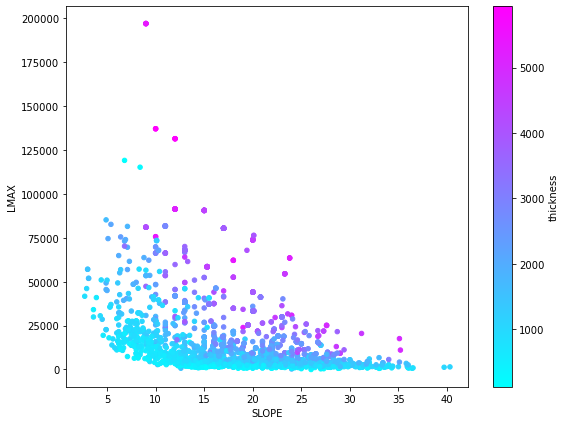

In [22]:
fig, ax = plt.subplots(figsize=(9,7))
df.plot.scatter(x='SLOPE', y='LMAX', c='thickness', cmap='cool', ax=ax)

In [13]:
df.apply(lambda x: x['ZMAX'] - x['ZMIN'] - x['LMAX'] * np.tan((x['SLOPE']/180 )*np.pi), axis=1)

0       -736.687681
1      -5869.340488
2      -1001.531411
3      -2246.084626
4      -6549.458056
           ...     
2195    -838.081561
2196   -1522.235620
2197   -1782.546254
2198   -1221.115441
2199   -1926.221171
Length: 2180, dtype: float64

<AxesSubplot:>

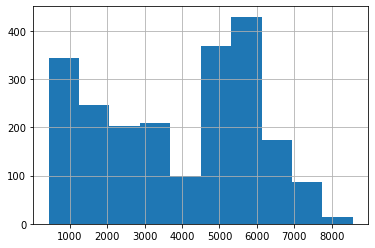

In [14]:
df.ZMAX.hist()

<AxesSubplot:>

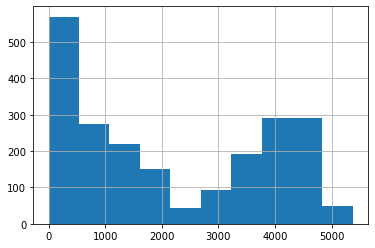

In [15]:
df.ZMIN.hist()

<AxesSubplot:>

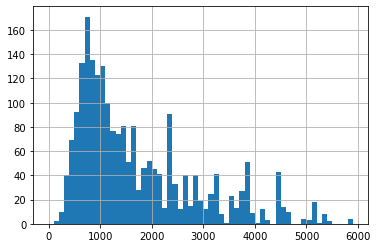

In [16]:
(df.ZMAX - df.ZMIN).hist(bins=np.arange(0, 6000, 100))

<AxesSubplot:>

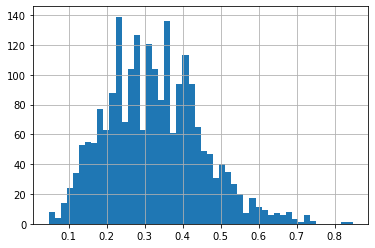

In [17]:
(df.SLOPE.apply(lambda x: np.tan(x*np.pi/180))).hist(bins=50)

<AxesSubplot:>

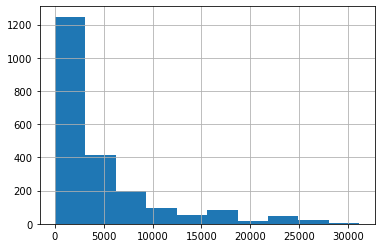

In [18]:
(df.SLOPE.apply(lambda x: np.tan(x*np.pi/180)) * df.LMAX).hist()